In [442]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import holidays
from geopy.distance import geodesic
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import optuna
from optuna import trial

In [443]:
df = pd.read_csv("TaxiFare.csv")
df.head(3)

unique_id  amount      date_time_of_pickup  longitude_of_pickup  \
0   26:21.0     4.5  2009-06-15 17:26:21 UTC           -73.844311   
1   52:16.0    16.9  2010-01-05 16:52:16 UTC           -74.016048   
2   35:00.0     5.7  2011-08-18 00:35:00 UTC           -73.982738   

   latitude_of_pickup  longitude_of_dropoff  latitude_of_dropoff  \
0           40.721319            -73.841610            40.712278   
1           40.711303            -73.979268            40.782004   
2           40.761270            -73.991242            40.750562   

   no_of_passenger  
0                1  
1                1  
2                2

# EDA and Feature Engineering

In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unique_id             50000 non-null  object 
 1   amount                50000 non-null  float64
 2   date_time_of_pickup   50000 non-null  object 
 3   longitude_of_pickup   50000 non-null  float64
 4   latitude_of_pickup    50000 non-null  float64
 5   longitude_of_dropoff  50000 non-null  float64
 6   latitude_of_dropoff   50000 non-null  float64
 7   no_of_passenger       50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [445]:
# checking for null
df.isnull().sum()

unique_id               0
amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64

## Extracting Prameters of Time.

In [446]:
df.drop(columns="unique_id", inplace=True)

# convert UTC to NYC timezone
df["nyc_time"] = pd.to_datetime(df["date_time_of_pickup"]) - pd.Timedelta(hours=4)
df.drop(columns="date_time_of_pickup", inplace=True)

df.head(2)

amount  longitude_of_pickup  latitude_of_pickup  longitude_of_dropoff  \
0     4.5           -73.844311           40.721319            -73.841610   
1    16.9           -74.016048           40.711303            -73.979268   

   latitude_of_dropoff  no_of_passenger                  nyc_time  
0            40.712278                1 2009-06-15 13:26:21+00:00  
1            40.782004                1 2010-01-05 12:52:16+00:00

In [447]:
# extracting months, years, hours, minutes from timestamp

df["year"] = df["nyc_time"].dt.year
df["month"] = df["nyc_time"].dt.month

df["hours"] = df["nyc_time"].dt.hour
df["minutes"] = df["nyc_time"].dt.minute

In [448]:
# calculating ride start time out of 100 instead of 60 minutes

def minute_convertor(x):
    if x < 15:
        return 0
    if x < 30:
        return 0.25
    if x < 45:
        return 0.5
    return 0.75


df["ride_start_time"] = df["hours"] + df["minutes"].apply(lambda x: minute_convertor(x))

In [449]:
# marking weekends
df["weekend/holiday"] = np.where(df["nyc_time"].dt.day_of_week > 4, 1,0)

# marking holidays
nyc_holidays = holidays.US(years = df["year"].unique(), state="NY")
df["weekend/holiday"] = np.where(df["nyc_time"].dt.date.isin(nyc_holidays),1, df["weekend/holiday"])

## Filtering only New York data

In [468]:
# dropping latittudes and longitudes outside of NYC

min_lat, max_lat =  40.3, 45.1
min_long, max_long = -71.5, -79.5

pickup_mask = (df["latitude_of_pickup"] >= min_lat) & (df["latitude_of_pickup"] <= max_lat) \
                & (df["longitude_of_pickup"] <= min_long) & (df["longitude_of_pickup"] >= max_long)
droppoff_mask = (df["latitude_of_dropoff"] >= min_lat) & (df["latitude_of_dropoff"] <= max_lat) \
                & (df["longitude_of_dropoff"] <= min_long) & (df["longitude_of_dropoff"] >= max_long)

nyc_df = df[(pickup_mask) & (droppoff_mask)].copy()

## Calculating Haversine distance from Pickup and Dropoff Latitudes and Longitudes

In [469]:
# calculatiing haversine distance
def haversine_distance(row):
    """
    Function that calculates Haversine Distance between pair of cordinates(lat, long)
    """
    pickup = (row.loc["latitude_of_pickup"], row.loc["longitude_of_pickup"])
    drop = (row.loc["latitude_of_dropoff"], row.loc["longitude_of_dropoff"])
    distance = geodesic(pickup, drop).km
    return distance

nyc_df["haversine_distance"] = nyc_df.apply(lambda x: haversine_distance(x), axis=1)    

## Analyzing Label: Amount

In [470]:
nyc_df["amount"].sort_values()[:10]

42337   -5.00
13032   -3.00
2039    -2.90
2486    -2.50
36722   -2.50
47302    0.00
27891    0.00
10002    0.00
2780     0.01
10705    2.50
Name: amount, dtype: float64

In [471]:
# dropping where amount < 2$ (assuming base fare=2$)
nyc_df.drop(nyc_df[nyc_df["amount"] < 2].index, inplace=True)

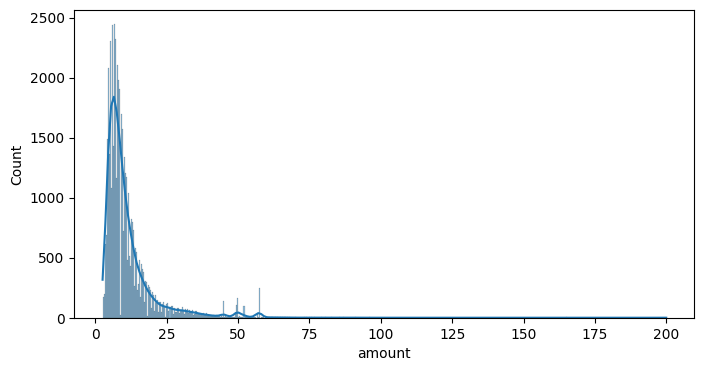

In [472]:
# output column
plt.figure(figsize=(8,4))
sns.histplot((nyc_df["amount"]), kde=True)
plt.show()

There are a lot of extreme ride fares that need to be handled or transformed. We can take log transform.


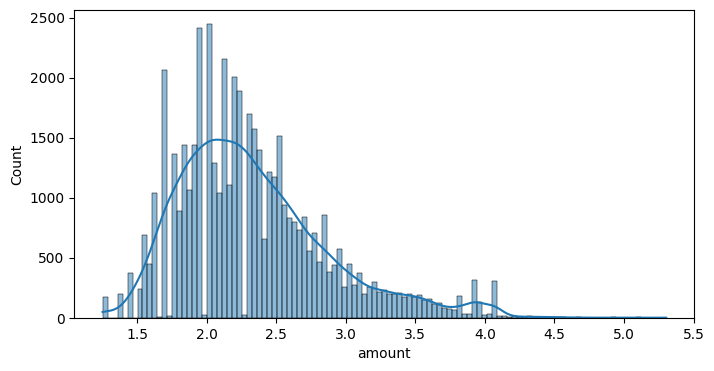

In [473]:
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(nyc_df["amount"]), kde=True)
plt.show()

## Analyzing Features

In [474]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48945 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   amount                48945 non-null  float64            
 1   longitude_of_pickup   48945 non-null  float64            
 2   latitude_of_pickup    48945 non-null  float64            
 3   longitude_of_dropoff  48945 non-null  float64            
 4   latitude_of_dropoff   48945 non-null  float64            
 5   no_of_passenger       48945 non-null  int64              
 6   nyc_time              48945 non-null  datetime64[ns, UTC]
 7   year                  48945 non-null  int32              
 8   month                 48945 non-null  int32              
 9   hours                 48945 non-null  int32              
 10  minutes               48945 non-null  int32              
 11  ride_start_time       48945 non-null  float64            
 12  weekend/h

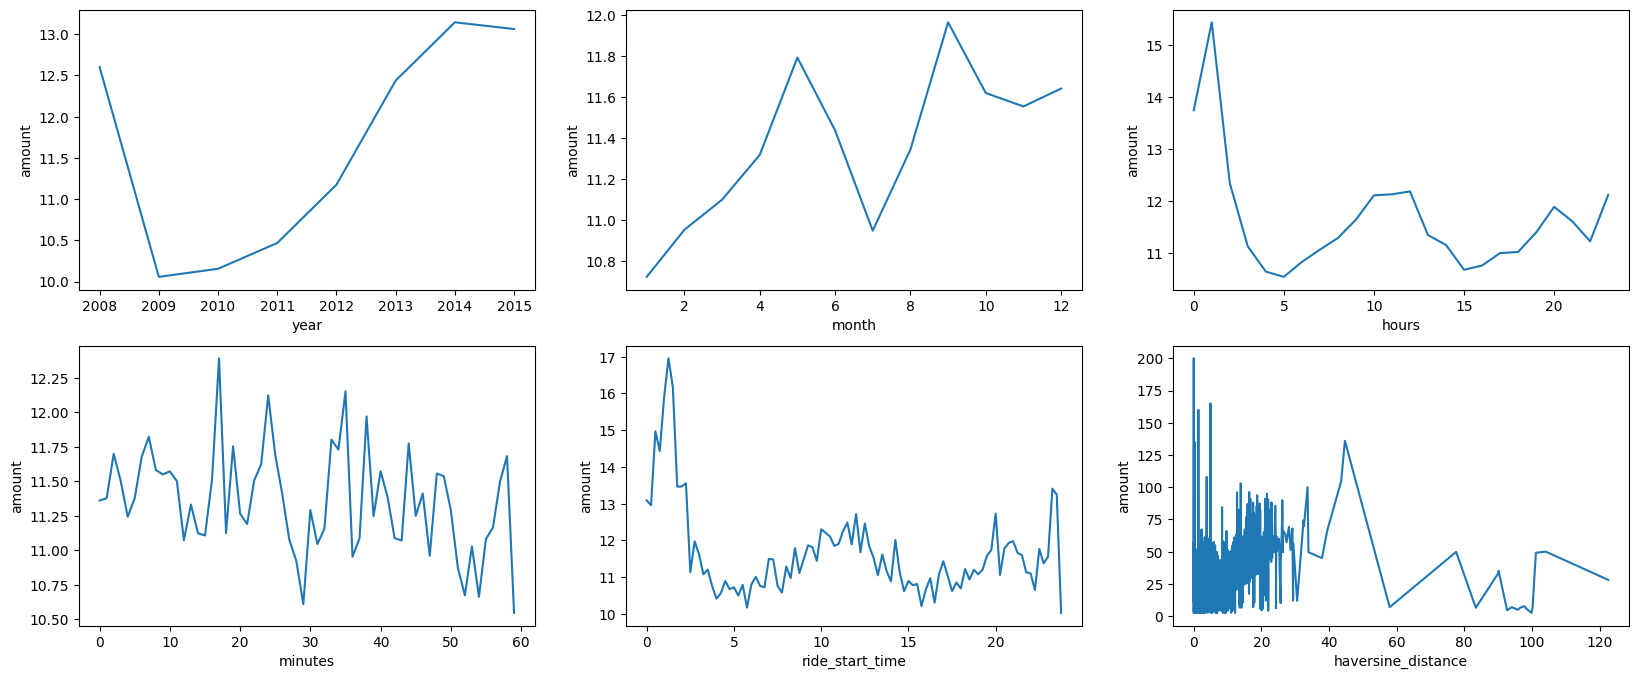

In [475]:
line_plot = ['year', 'month', 'hours', 'minutes', 'ride_start_time', 'haversine_distance']

fig, axs = plt.subplots(2,3, figsize=(20,8))
for ind, col in enumerate(line_plot):
    sns.lineplot(nyc_df, x=col, y="amount", ax=axs[ind//3, ind%3], errorbar=None)

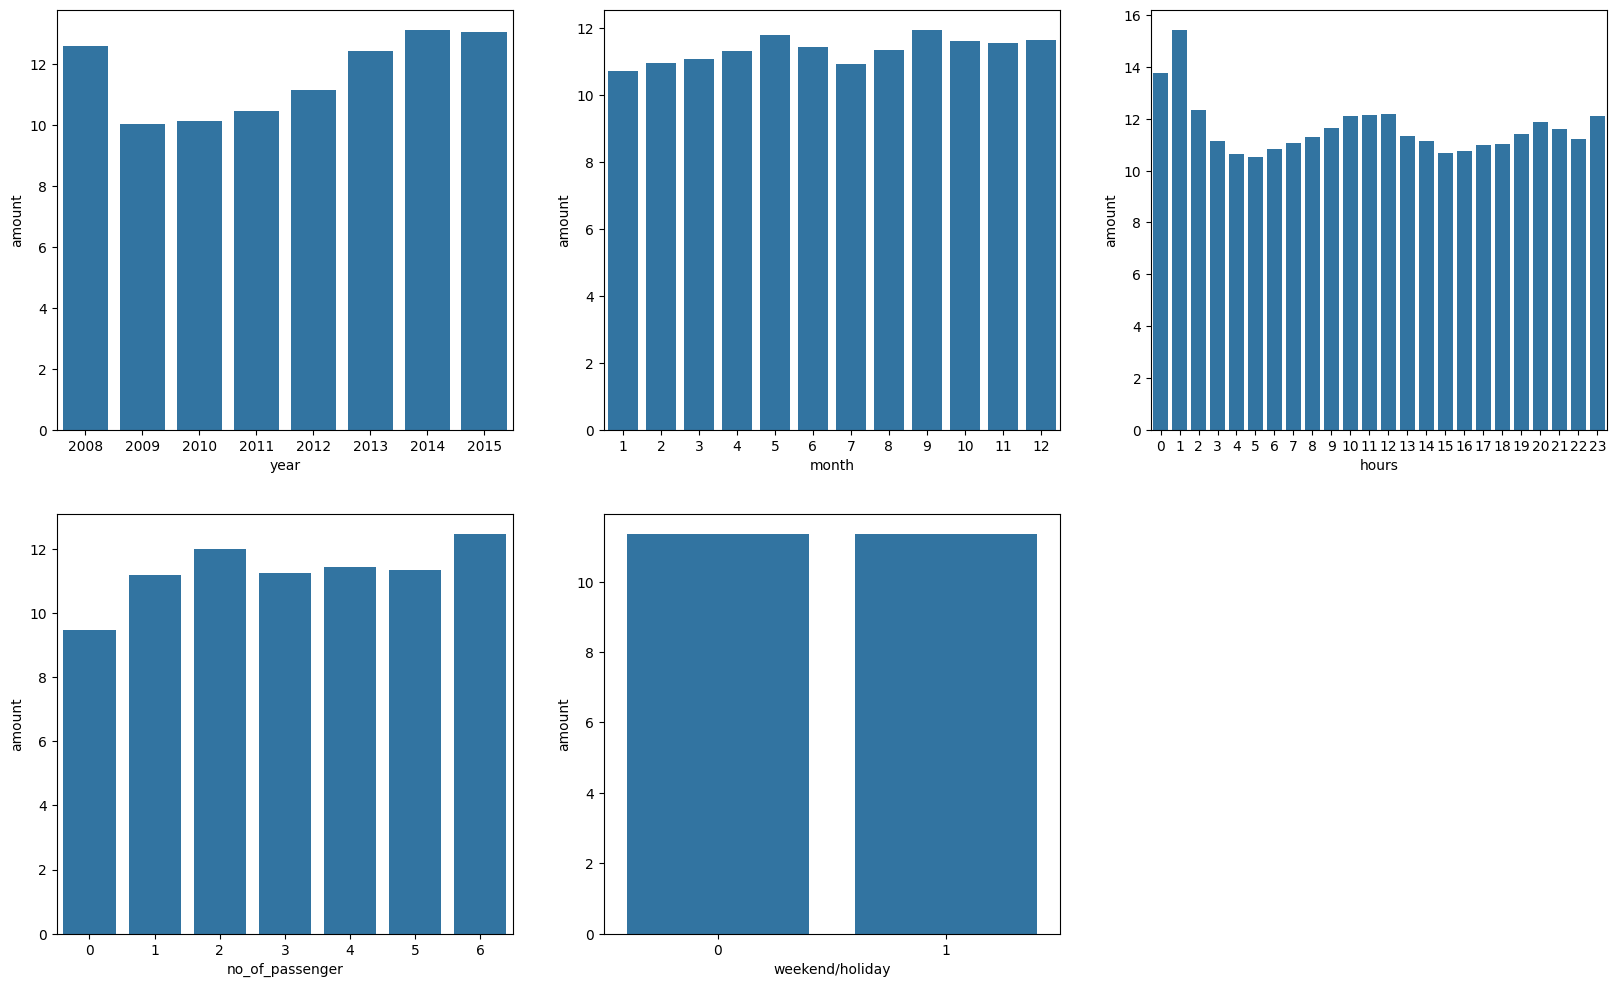

In [476]:
bar_chart = ['year', 'month', 'hours','no_of_passenger','weekend/holiday']

fig, axs = plt.subplots(2,3, figsize=(20,12))
for ind, col in enumerate(bar_chart):
    sns.barplot(nyc_df, x=col, y="amount", errorbar=None, ax=axs[ind//3, ind%3])

for col in range(len(bar_chart)%3,3):
    axs[-1][col].remove()

- there is a sudden fall in average fare price in 2009, indicating the effect of The Great Recession
- May and September have slightly higher fare prices than other months.
- Late night hours 12-2 AM have higher average fare prices.
- Prices during peak hours 10-12PM and 7-9PM are also high.
- Normal days and Weekend/Holidays seems to have no difference in average price.
   

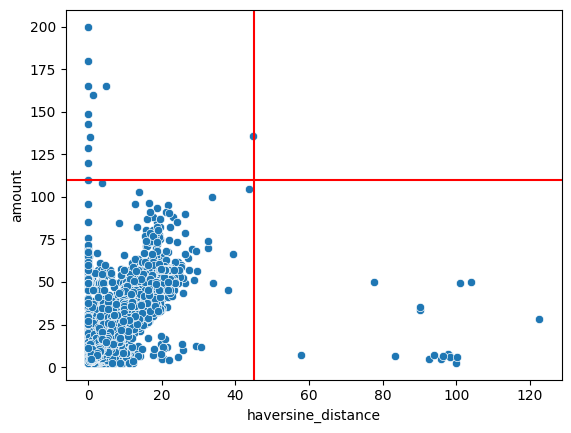

In [477]:
sns.scatterplot(nyc_df, x="haversine_distance", y="amount")
plt.axvline(x=45, c="r")
plt.axhline(y=110, c="r")
plt.show()

In [478]:
nyc_df[(nyc_df["amount"] > 110) | (nyc_df["haversine_distance"] > 45)].shape

(28, 14)

- Most of the data is confined between Red lines region and there are few outliers(28 points)
- We treat them as outliers:
 
  (a). Even though the distance is greater than 45, their price is fairly low i.e less than 50$.
   
  (b). Even if distance is around 0 km, price is much high i.e greater than 110$

so we can remove these 28 data points

In [479]:
nyc_df.drop(nyc_df[(nyc_df["amount"] > 110) | (nyc_df["haversine_distance"] > 45)].index, inplace=True)

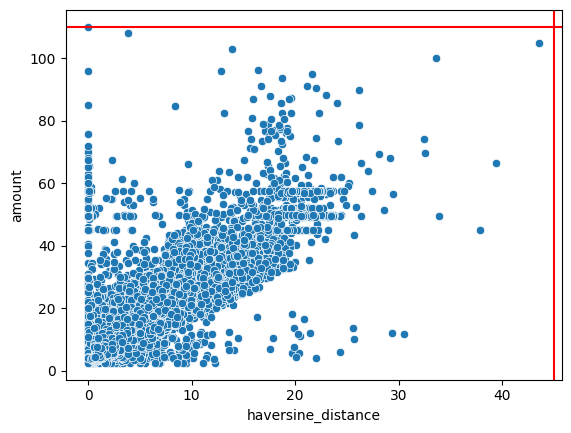

In [480]:
sns.scatterplot(nyc_df, x="haversine_distance", y="amount")
plt.axvline(x=45, c="r")
plt.axhline(y=110, c="r")
plt.show()

In [481]:
# removing distance less than 0.5km
nyc_zero_handle = nyc_df[nyc_df["haversine_distance"]>0.5].copy()

## Analyzing Zero Number of Passenger

In [482]:
nyc_df["no_of_passenger"].value_counts()


no_of_passenger
1    34019
2     7248
5     3380
3     2145
4      990
6      976
0      159
Name: count, dtype: int64

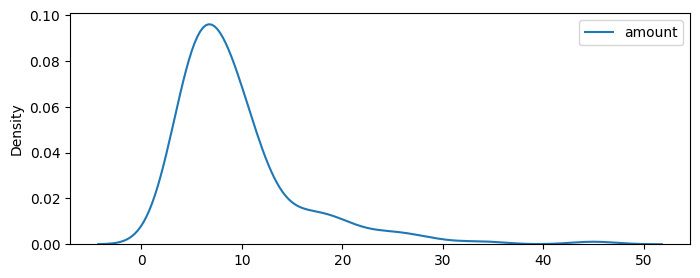

In [483]:
plt.figure(figsize=(8,3))
sns.kdeplot(nyc_df.loc[nyc_df["no_of_passenger"]==0, ["amount"]])
plt.show()

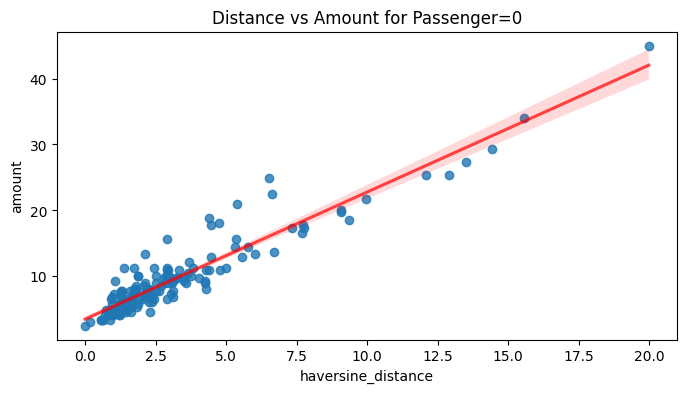

In [484]:
plt.figure(figsize=(8,4))
sns.regplot(nyc_df.loc[nyc_df["no_of_passenger"]==0, ["amount", "haversine_distance"]], 
            x="haversine_distance", y="amount",line_kws=dict(color="r", alpha=0.7))
plt.title("Distance vs Amount for Passenger=0")
plt.show()

- The above regplot shows there is linear relation between haversin_distance and amount.
- This indicates that 0 passenger is the case where some goods are being transported.
- We can check our model performance by both keeping and dropping these.

In [485]:
nyc_full = nyc_df.copy()
nyc_df = nyc_df.drop(nyc_df[nyc_df["no_of_passenger"]==0].index).copy()

## Removing points in water

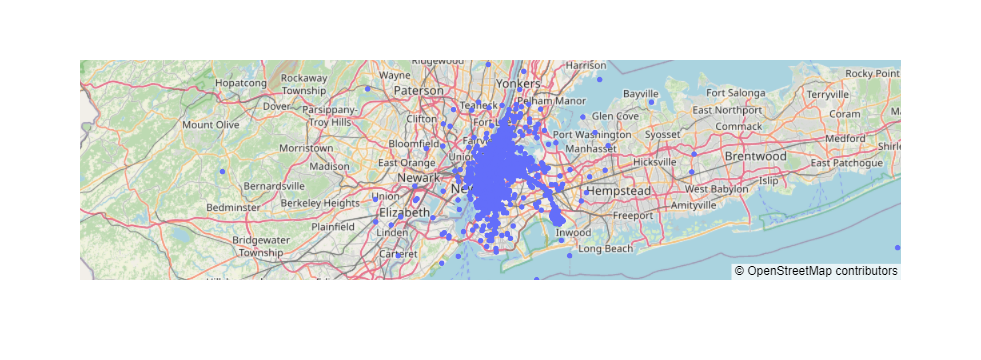

In [486]:
import plotly.express as px

fig = px.scatter_mapbox(nyc_df,lat= "latitude_of_pickup",lon= "longitude_of_pickup",
                            mapbox_style = "open-street-map")

fig.show()

In [487]:
water_points = [(40.58923, -72.85697), (40.57241, -73.75795), (40.45954, -73.80835), 
          (40.30777, -73.64495), (40.52226, -73.84848), (40.93889, -73.67558), (40.57131, -74.06406)]

In [488]:
# dropping water points
for points in water_points:
    ind = nyc_df[(np.round(nyc_df["latitude_of_pickup"],5) == points[0]) & 
            (np.round(nyc_df["longitude_of_pickup"],5) == points[1])].index
    if not any(ind):
        ind = nyc_df[(np.round(nyc_df["latitude_of_dropoff"],5) == points[0]) & 
                (np.round(nyc_df["longitude_of_dropoff"],5) == points[1])].index

    nyc_df.drop(index=ind, inplace=True)
    

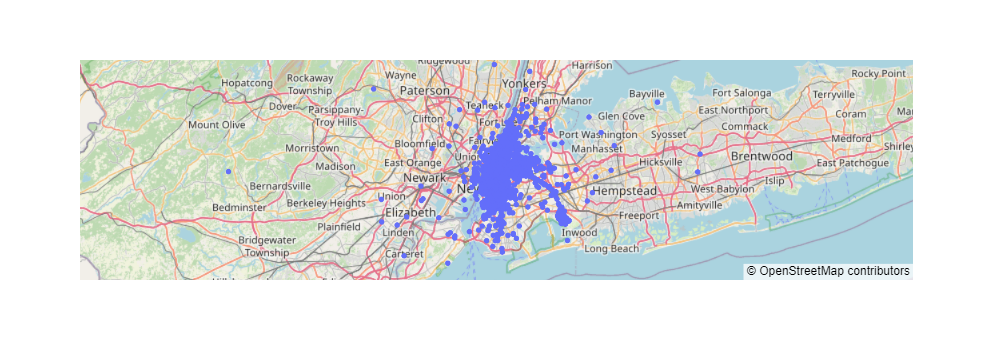

In [489]:
fig = px.scatter_mapbox(nyc_df,lat= "latitude_of_pickup",lon= "longitude_of_pickup",
                            mapbox_style = "open-street-map")

fig.show()

In [490]:
nyc_df.shape

(48751, 14)

## Splitting into Train and Test sets

In [491]:
x = nyc_df.drop(columns=["amount", "nyc_time"]).copy()
y = nyc_df["amount"]
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=16)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((39000, 12), (39000,), (9751, 12), (9751,))

In [492]:
x = nyc_zero_handle.drop(columns=["amount", "nyc_time"]).copy()
y = nyc_zero_handle["amount"]
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=16)
x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape

((37579, 12), (37579,), (9395, 12), (9395,))

In [493]:
def evaluation(method, x_train, x_test, y_train, y_test, 
               model=None, result_df=pd.DataFrame(), 
               describe=False, transform=False, trans_obj=None):
    """
    method: Tuning parameter for reference
    x_train: trianing dataset to train the model
    x-test: testing dataset to test the model
    y_trian: label values of trainig dataset
    y_test: label values of testing dataset to evluate
    result_df: Dataframe to store the result of each model
    describe: set True, if you want description stats for each model
    tranform: {True, "log", "sqrt"} If label columns need to be reversed transformed. 
    trans_obj: if transform set to True, object needed to reverse transform label else performs log or sqrt depending on value of transform
    """
    
    model = model

    if not any(result_df):
        result_df = pd.DataFrame({
    "method": [],
    "r2_train": [],
    "r2_test":[],
    "adj_r2_train": [],
    "adj_r2_test": [],
    "train_rmse": [],
    "test_rmse": []
    })
    n_r_train, n_c_train = x_train.shape
    n_r_test, n_c_test = x_test.shape

    # model fit
    model.fit(x_train, y_train)
    
    # predict
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    
    # reverse transform
    if transform == "log":
        y_pred_train = np.exp(y_pred_train)
        y_pred_test = np.exp(y_pred_test)
    elif transform == "sqrt":
        y_pred_train = pow(y_pred_train,2)
        y_pred_test = pow(y_pred_test,2)
    elif transform:
        
        y_pred_train = trans_obj.inverse_transform(pd.DataFrame(y_pred_train))
        y_pred_test = trans_obj.inverse_transform(pd.DataFrame(y_pred_test))


    # r2 score
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # adjusted r2
    adj_r2_train = 1 - ((1-train_r2)*(n_r_train-1)/ (n_r_train-n_c_train-1))
    adj_r2_test = 1 - ((1-test_r2)*(n_r_test-1)/ (n_r_test-n_c_test-1))

    # rmse
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)

    # printing values
    if describe:
        print(f"r2 score---")
        print(f"train_r2: {round(train_r2,4)}, test_r2: {round(test_r2,4)}")
        print("-------------------------")
    
        print(f"Adj r2 score---")
        print(f"train_adj_r2: {round(adj_r2_train,4)}, test_adj_r2: {round(adj_r2_test,4)}")
        print("-------------------------")
        
        print(f"rmse score---")
        print(f"train_rmse: {round(train_rmse,4)}, test_rmse: {round(test_rmse,4)}")
        print("-------------------------")

    temp_df = pd.DataFrame({
    "method": [method],
    "r2_train": [round(train_r2,4)],
    "r2_test":[round(test_r2,4)],
    "adj_r2_train": [round(adj_r2_train,4)],
    "adj_r2_test": [round(adj_r2_test,4)],
    "train_rmse": [round(train_rmse,4)],
    "test_rmse": [round(test_rmse,4)]
    })
    result_df = pd.concat([result_df, temp_df]).reset_index(drop=True)
    return result_df

In [494]:
model = LinearRegression()
results = evaluation("Linear Regression", x_train1, x_test1, y_train1, y_test1,
           model=model)
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0  Linear Regression    0.8434   0.8246        0.8434       0.8243   

   train_rmse  test_rmse  
0      3.6962     3.7762

In [495]:
model = DecisionTreeRegressor(random_state=16)
results = evaluation("Decision Tree", x_train1, x_test1, y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0  Linear Regression    0.8434   0.8246        0.8434       0.8243   
1      Decision Tree    1.0000   0.7483        1.0000       0.7480   

   train_rmse  test_rmse  
0      3.6962     3.7762  
1      0.0000     4.5232

In [496]:
# grid = {
#     "max_depth": [5,6,7,8]
# }
# gcv = GridSearchCV(estimator=model, param_grid=grid, cv=3, n_jobs=-1, scoring="neg_root_mean_squared_error")
# gcv.fit(x_train1, y_train1)
# gcv.best_params_

In [497]:
params = {'max_depth': 6}
model = DecisionTreeRegressor(random_state=16, **params)
results = evaluation("Decision Tree + Tuned", x_train1, x_test1, y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0      Linear Regression    0.8434   0.8246        0.8434       0.8243   
1          Decision Tree    1.0000   0.7483        1.0000       0.7480   
2  Decision Tree + Tuned    0.8815   0.8372        0.8814       0.8370   

   train_rmse  test_rmse  
0      3.6962     3.7762  
1      0.0000     4.5232  
2      3.2158     3.6382

In [498]:
model = RandomForestRegressor(random_state=42)
results = evaluation("Random Forest", x_train1, x_test1, y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0      Linear Regression    0.8434   0.8246        0.8434       0.8243   
1          Decision Tree    1.0000   0.7483        1.0000       0.7480   
2  Decision Tree + Tuned    0.8815   0.8372        0.8814       0.8370   
3          Random Forest    0.9846   0.8632        0.9846       0.8630   

   train_rmse  test_rmse  
0      3.6962     3.7762  
1      0.0000     4.5232  
2      3.2158     3.6382  
3      1.1573     3.3351

In [499]:
pd.DataFrame({"feature" : model.feature_names_in_,
 "importance": model.feature_importances_})

feature  importance
0    longitude_of_pickup    0.020321
1     latitude_of_pickup    0.013368
2   longitude_of_dropoff    0.038401
3    latitude_of_dropoff    0.021134
4        no_of_passenger    0.002655
5                   year    0.023781
6                  month    0.006885
7                  hours    0.004262
8                minutes    0.008650
9        ride_start_time    0.011673
10       weekend/holiday    0.001663
11    haversine_distance    0.847207

In [500]:
imp_cols = ["haversine_distance", "ride_start_time", "year"]
model = RandomForestRegressor(random_state=42)
results = evaluation("Random Forest with imp cols", x_train1[imp_cols], x_test1[imp_cols], y_train1, y_test1,
           model=model, result_df=results)


In [501]:
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0            Linear Regression    0.8434   0.8246        0.8434       0.8243   
1                Decision Tree    1.0000   0.7483        1.0000       0.7480   
2        Decision Tree + Tuned    0.8815   0.8372        0.8814       0.8370   
3                Random Forest    0.9846   0.8632        0.9846       0.8630   
4  Random Forest with imp cols    0.9766   0.8225        0.9766       0.8224   

   train_rmse  test_rmse  
0      3.6962     3.7762  
1      0.0000     4.5232  
2      3.2158     3.6382  
3      1.1573     3.3351  
4      1.4284     3.7988

In [502]:
imp_cols2 = ["haversine_distance", "ride_start_time", "year", "longitude_of_pickup",
            "latitude_of_pickup", "longitude_of_dropoff", "latitude_of_dropoff"]
results = evaluation("Random Forest with imp cols2", x_train1[imp_cols2], x_test1[imp_cols2], y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0             Linear Regression    0.8434   0.8246        0.8434       0.8243   
1                 Decision Tree    1.0000   0.7483        1.0000       0.7480   
2         Decision Tree + Tuned    0.8815   0.8372        0.8814       0.8370   
3                 Random Forest    0.9846   0.8632        0.9846       0.8630   
4   Random Forest with imp cols    0.9766   0.8225        0.9766       0.8224   
5  Random Forest with imp cols2    0.9845   0.8625        0.9845       0.8624   

   train_rmse  test_rmse  
0      3.6962     3.7762  
1      0.0000     4.5232  
2      3.2158     3.6382  
3      1.1573     3.3351  
4      1.4284     3.7988  
5      1.1623     3.3433

## Scalling

In [503]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train_sc = pd.DataFrame(data=sc.fit_transform(x_train),
                            columns=sc.get_feature_names_out())

x_test_sc = pd.DataFrame(data=sc.transform(x_test),
                        columns=sc.get_feature_names_out())


In [504]:
sc = StandardScaler()

x_train_sc1 = pd.DataFrame(data=sc.fit_transform(x_train1),
                            columns=sc.get_feature_names_out())

x_test_sc1 = pd.DataFrame(data=sc.transform(x_test1),
                        columns=sc.get_feature_names_out())

In [505]:
model = RandomForestRegressor(random_state=42)
results = evaluation("Random Forest scalled", x_train_sc1, x_test_sc1, y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0             Linear Regression    0.8434   0.8246        0.8434       0.8243   
1                 Decision Tree    1.0000   0.7483        1.0000       0.7480   
2         Decision Tree + Tuned    0.8815   0.8372        0.8814       0.8370   
3                 Random Forest    0.9846   0.8632        0.9846       0.8630   
4   Random Forest with imp cols    0.9766   0.8225        0.9766       0.8224   
5  Random Forest with imp cols2    0.9845   0.8625        0.9845       0.8624   
6         Random Forest scalled    0.9846   0.8635        0.9846       0.8633   

   train_rmse  test_rmse  
0      3.6962     3.7762  
1      0.0000     4.5232  
2      3.2158     3.6382  
3      1.1573     3.3351  
4      1.4284     3.7988  
5      1.1623     3.3433  
6      1.1586     3.3309

In [506]:
model = RandomForestRegressor(random_state=42)
results = evaluation("Random Forest scalled + imp_cols2", x_train_sc1[imp_cols2], x_test_sc1[imp_cols2], y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  \
0                  Linear Regression    0.8434   0.8246        0.8434   
1                      Decision Tree    1.0000   0.7483        1.0000   
2              Decision Tree + Tuned    0.8815   0.8372        0.8814   
3                      Random Forest    0.9846   0.8632        0.9846   
4        Random Forest with imp cols    0.9766   0.8225        0.9766   
5       Random Forest with imp cols2    0.9845   0.8625        0.9845   
6              Random Forest scalled    0.9846   0.8635        0.9846   
7  Random Forest scalled + imp_cols2    0.9845   0.8628        0.9845   

   adj_r2_test  train_rmse  test_rmse  
0       0.8243      3.6962     3.7762  
1       0.7480      0.0000     4.5232  
2       0.8370      3.2158     3.6382  
3       0.8630      1.1573     3.3351  
4       0.8224      1.4284     3.7988  
5       0.8624      1.1623     3.3433  
6       0.8633      1.1586     3.3309  
7       0.8627      1.1645     3.3390

## Creating Optuna Study


In [188]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50,250)
    max_depth = trial.suggest_int("max_depth", 2,15)
    
    model = RandomForestRegressor(random_state=16,
                                 n_estimators=n_estimators,
                                 max_depth= max_depth)
    score = -np.mean(cross_val_score(model, x_train, y_train, cv=5, n_jobs=-1, scoring="neg_root_mean_squared_error"))
    return score

In [189]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True,n_jobs=-1)
study.best_params

[I 2024-04-14 21:33:41,765] A new study created in memory with name: no-name-60e1a547-e1ff-4a6a-bc4f-365dbdd805e9


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-04-14 21:34:54,984] Trial 0 finished with value: 3.8343299370434236 and parameters: {'n_estimators': 198, 'max_depth': 9}. Best is trial 0 with value: 3.8343299370434236.
[I 2024-04-14 21:36:01,950] Trial 3 finished with value: 3.9322844775717307 and parameters: {'n_estimators': 57, 'max_depth': 6}. Best is trial 0 with value: 3.8343299370434236.
[I 2024-04-14 21:36:20,696] Trial 4 finished with value: 3.834566322196764 and parameters: {'n_estimators': 158, 'max_depth': 9}. Best is trial 0 with value: 3.8343299370434236.
[I 2024-04-14 21:36:40,571] Trial 7 finished with value: 3.822178310749446 and parameters: {'n_estimators': 104, 'max_depth': 15}. Best is trial 7 with value: 3.822178310749446.
[I 2024-04-14 21:36:42,628] Trial 1 finished with value: 3.8191560730549625 and parameters: {'n_estimators': 112, 'max_depth': 10}. Best is trial 1 with value: 3.8191560730549625.
[I 2024-04-14 21:37:11,681] Trial 2 finished with value: 3.825297657844268 and parameters: {'n_estimators':

{'n_estimators': 246, 'max_depth': 15}

In [507]:
params1 = {'n_estimators': 114, 'max_depth': 9}
params2 = {'n_estimators': 244, 'max_depth': 14}
params3 = {'n_estimators': 246, 'max_depth': 15}

In [508]:
model = RandomForestRegressor(random_state=16, **params1)
results = evaluation("Random Forest scalled Params1", x_train_sc1, x_test_sc1, y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  \
0                  Linear Regression    0.8434   0.8246        0.8434   
1                      Decision Tree    1.0000   0.7483        1.0000   
2              Decision Tree + Tuned    0.8815   0.8372        0.8814   
3                      Random Forest    0.9846   0.8632        0.9846   
4        Random Forest with imp cols    0.9766   0.8225        0.9766   
5       Random Forest with imp cols2    0.9845   0.8625        0.9845   
6              Random Forest scalled    0.9846   0.8635        0.9846   
7  Random Forest scalled + imp_cols2    0.9845   0.8628        0.9845   
8      Random Forest scalled Params1    0.9187   0.8581        0.9187   

   adj_r2_test  train_rmse  test_rmse  
0       0.8243      3.6962     3.7762  
1       0.7480      0.0000     4.5232  
2       0.8370      3.2158     3.6382  
3       0.8630      1.1573     3.3351  
4       0.8224      1.4284     3.7988  
5       0.8624      1.1623     3.3433  
6       0.8633      1.1586     3.3309  
7       0.8627      1.1645     3.3390  
8       0.8579      2.6630     3.3962

In [509]:
results

method  r2_train  r2_test  adj_r2_train  \
0                  Linear Regression    0.8434   0.8246        0.8434   
1                      Decision Tree    1.0000   0.7483        1.0000   
2              Decision Tree + Tuned    0.8815   0.8372        0.8814   
3                      Random Forest    0.9846   0.8632        0.9846   
4        Random Forest with imp cols    0.9766   0.8225        0.9766   
5       Random Forest with imp cols2    0.9845   0.8625        0.9845   
6              Random Forest scalled    0.9846   0.8635        0.9846   
7  Random Forest scalled + imp_cols2    0.9845   0.8628        0.9845   
8      Random Forest scalled Params1    0.9187   0.8581        0.9187   

   adj_r2_test  train_rmse  test_rmse  
0       0.8243      3.6962     3.7762  
1       0.7480      0.0000     4.5232  
2       0.8370      3.2158     3.6382  
3       0.8630      1.1573     3.3351  
4       0.8224      1.4284     3.7988  
5       0.8624      1.1623     3.3433  
6       0.8633      1.1586     3.3309  
7       0.8627      1.1645     3.3390  
8       0.8579      2.6630     3.3962

In [306]:
model = RandomForestRegressor(random_state=16, **params2)
results = evaluation("Random Forest scalled Params2", x_train_sc1, x_test_sc1, y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  \
0                  Linear Regression    0.8434   0.8246        0.8434   
1                      Decision Tree    1.0000   0.7483        1.0000   
2              Decision Tree + Tuned    0.8815   0.8372        0.8814   
3                      Random Forest    0.9846   0.8632        0.9846   
4        Random Forest with imp cols    0.9766   0.8225        0.9766   
5       Random Forest with imp cols2    0.9845   0.8625        0.9845   
6              Random Forest scalled    0.9846   0.8635        0.9846   
7  Random Forest scalled + imp_cols2    0.9845   0.8628        0.9845   
8      Random Forest scalled Params1    0.9187   0.8581        0.9187   
9      Random Forest scalled Params2    0.9600   0.8613        0.9599   

   adj_r2_test  train_rmse  test_rmse  
0       0.8243      3.6962     3.7762  
1       0.7480      0.0000     4.5232  
2       0.8370      3.2158     3.6382  
3       0.8630      1.1573     3.3351  
4       0.8224      1.4284     3.7988  
5       0.8624      1.1623     3.3433  
6       0.8633      1.1586     3.3309  
7       0.8627      1.1645     3.3390  
8       0.8579      2.6630     3.3962  
9       0.8611      1.8690     3.3578

In [307]:
model = RandomForestRegressor(random_state=16, **params3)
results = evaluation("Random Forest scalled Params3", x_train_sc1, x_test_sc1, y_train1, y_test1,
           model=model, result_df=results)
results

method  r2_train  r2_test  adj_r2_train  \
0                   Linear Regression    0.8434   0.8246        0.8434   
1                       Decision Tree    1.0000   0.7483        1.0000   
2               Decision Tree + Tuned    0.8815   0.8372        0.8814   
3                       Random Forest    0.9846   0.8632        0.9846   
4         Random Forest with imp cols    0.9766   0.8225        0.9766   
5        Random Forest with imp cols2    0.9845   0.8625        0.9845   
6               Random Forest scalled    0.9846   0.8635        0.9846   
7   Random Forest scalled + imp_cols2    0.9845   0.8628        0.9845   
8       Random Forest scalled Params1    0.9187   0.8581        0.9187   
9       Random Forest scalled Params2    0.9600   0.8613        0.9599   
10      Random Forest scalled Params3    0.9656   0.8621        0.9656   

    adj_r2_test  train_rmse  test_rmse  
0        0.8243      3.6962     3.7762  
1        0.7480      0.0000     4.5232  
2        0.8370      3.2158     3.6382  
3        0.8630      1.1573     3.3351  
4        0.8224      1.4284     3.7988  
5        0.8624      1.1623     3.3433  
6        0.8633      1.1586     3.3309  
7        0.8627      1.1645     3.3390  
8        0.8579      2.6630     3.3962  
9        0.8611      1.8690     3.3578  
10       0.8619      1.7329     3.3484

In [206]:
params1
# 120-9:3.7227
# 150-9:3.7219
# 150-10: 3.7166
# 160-10: 3.7148
# 170-10: 3.7099
# 180-10: 3.7062
# 200-10: 3.7082
# 200-12: 3.7099



{'n_estimators': 114, 'max_depth': 9}

In [510]:
params = {'n_estimators': 180, 'max_depth': 10}
model = RandomForestRegressor(random_state=16, **params)
evaluation("Random Forest scalled 180-10", x_train_sc1, x_test_sc1, y_train1, y_test1,
           model=model)

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0  Random Forest scalled 180-10    0.9283    0.859        0.9283       0.8588   

   train_rmse  test_rmse  
0       2.501     3.3853

In [211]:
params

{'n_estimators': 200, 'max_depth': 12}

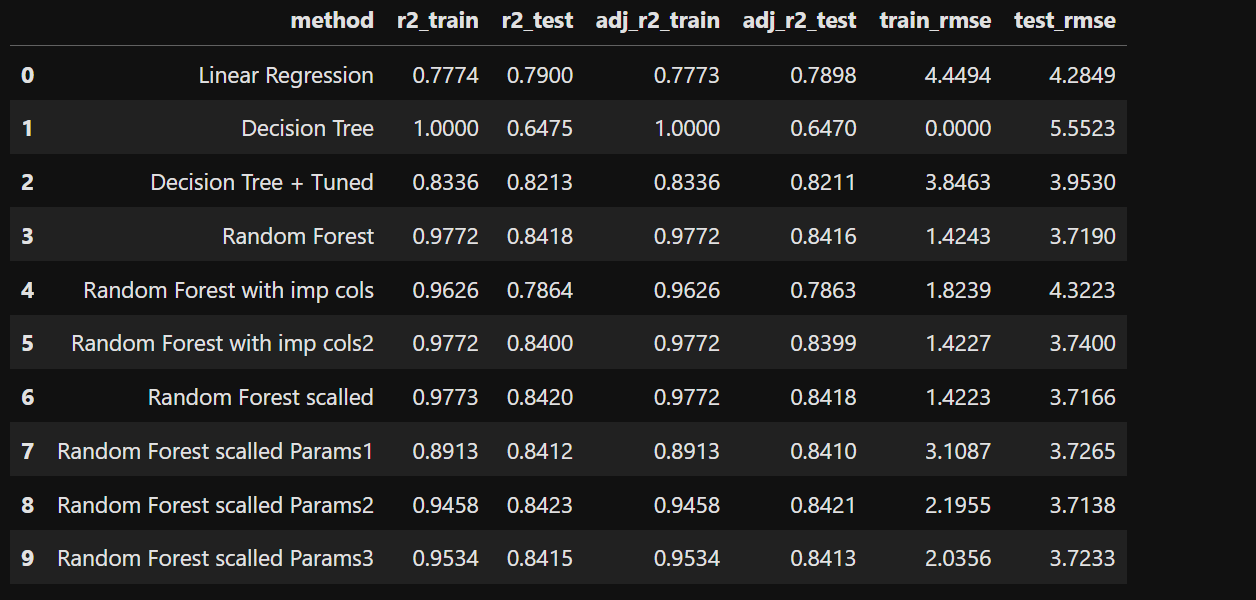

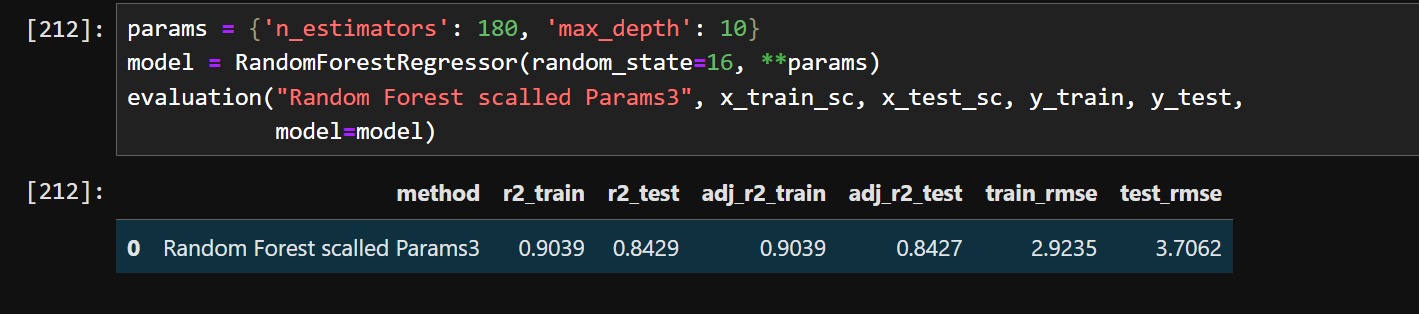

In [96]:
model = RandomForestRegressor(random_state=16, **params2)
results = evaluation("Random Forest Fine Tuned", x_train, x_test, y_train, y_test,
           model=model, result_df=results)

In [97]:
results

method  r2_train  r2_test  adj_r2_train  adj_r2_test  \
0         Linear Regression    0.7774   0.7900        0.7773       0.7898   
1             Decision Tree    1.0000   0.6475        1.0000       0.6470   
2     Decision Tree + Tuned    0.8336   0.8213        0.8336       0.8211   
3             Random Forest    0.9779   0.8418        0.9778       0.8416   
4   Decision Tree + Tuned:8    0.8660   0.8186        0.8660       0.8184   
5       Random Forest Tuned    0.8771   0.8412        0.8771       0.8410   
6  Random Forest Fine Tuned    0.9458   0.8422        0.9457       0.8420   

   train_rmse  test_rmse  
0      4.4494     4.2849  
1      0.0000     5.5523  
2      3.8463     3.9530  
3      1.4035     3.7198  
4      3.4522     3.9828  
5      3.3055     3.7270  
6      2.1964     3.7151

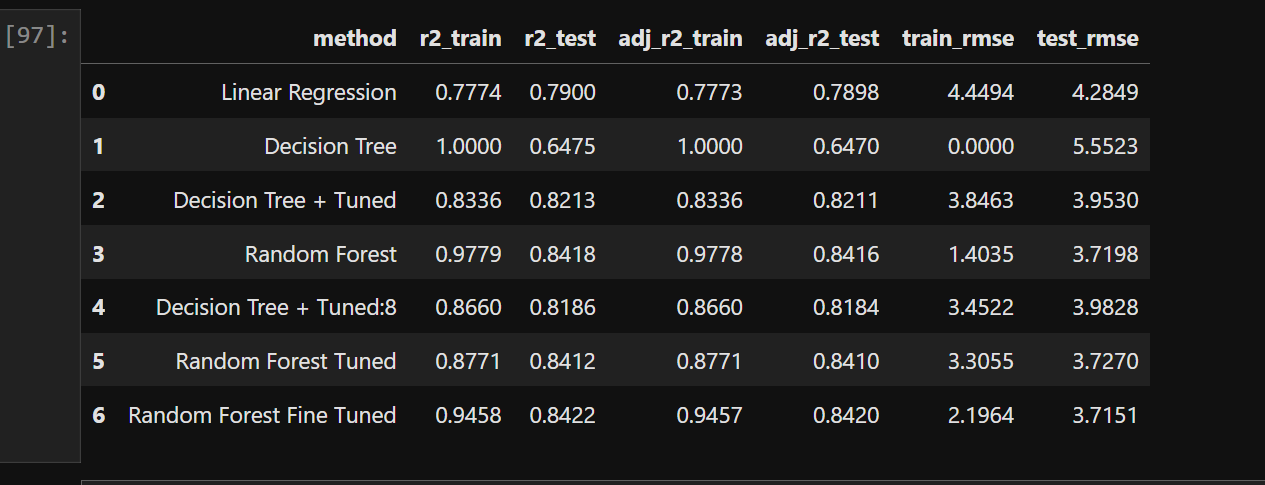